In [176]:
import pandas as pd
import missingno as msn
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np

In [177]:

date_cols = ['Fecha de Inicio del Contrato']

df = pd.read_csv('C:/Users/User/Downloads/ds4a-secopII/SECOP_Electronicos_Cleaned.csv',  parse_dates=date_cols)

In [178]:
df['Fecha de Inicio del Contrato'].dt.year

0          2022
1          2020
2          2021
3          2018
4          2022
           ... 
1585893    2021
1585894    2021
1585895    2021
1585896    2021
1585897    2021
Name: Fecha de Inicio del Contrato, Length: 1585898, dtype: int64

In [138]:
df = df[df['Fecha de Inicio del Contrato'].dt.year > 2019].drop('Unnamed: 0', axis=1)

#df = df[ pd.DataFrame(df['Fecha de Fin del Contrato'].str.split('/').to_list()).iloc[:,2].astype(int) < 2023 ]

df.shape

(1253547, 26)

In [139]:
df.columns

Index(['Departamento', 'Orden', 'Sector', 'Rama', 'Entidad Centralizada',
       'Estado Contrato', 'Tipo de Contrato', 'Modalidad de Contratacion',
       'Fecha de Inicio del Contrato', 'Fecha de Fin del Contrato', 'Es Grupo',
       'Es Pyme', 'Obligación Ambiental', 'Obligaciones Postconsumo',
       'Valor del Contrato', 'Valor de pago adelantado', 'Valor Facturado',
       'Valor Pendiente de Pago', 'Valor Pagado', 'Valor Amortizado',
       'Valor Pendiente de Amortizacion', 'Valor Pendiente de Ejecucion',
       'EsPostConflicto', 'Destino Gasto', 'Origen de los Recursos',
       'Dias Adicionados'],
      dtype='object')

<AxesSubplot:>

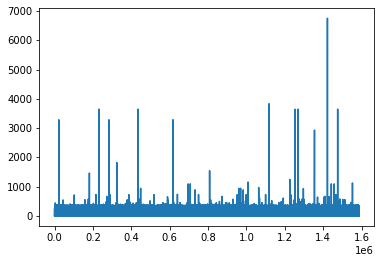

In [140]:
df['Dias Adicionados'].plot()

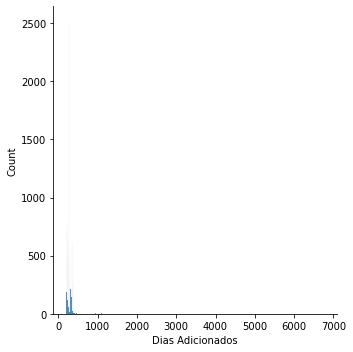

In [141]:
sns.displot(df[df['Dias Adicionados']>200]['Dias Adicionados'])#.#describe()

In [142]:
#Duracion del Contrato
##abs(df['Fecha de Inicio del Contrato'][3]-df['Fecha de Inicio del Contrato'][0])


In [143]:
#Normalizar el delay
def feature_engineer(days_added, date_init, date_finish):
    
    contract_duration = abs(date_init - date_finish).days
    Normalized_Delay = days_added/contract_duration
    
    if Normalized_Delay == 0:
        delay = 0
    elif Normalized_Delay > 0 and Normalized_Delay < 0.2:
        delay = 1
    elif Normalized_Delay >= 0.2 and Normalized_Delay < 0.7:
        delay = 2
    elif Normalized_Delay >= 0.7: 
        delay = 3
            
    return delay

In [ ]:
df['Delay'] = df.apply(lambda x: feature_engineer(x['Dias Adicionados'],
                                                  x['Fecha de Inicio del Contrato'],
                                                  pd.Timestamp(x['Fecha de Fin del Contrato'])), axis=1)
#df['Dias Adicionados'].apply(feature_engineer)

In [172]:
df['Fecha de Fin del Contrato'].str.extract('*')

error: nothing to repeat at position 0

In [166]:
df['Fecha de Fin del Contrato'].values[0][6:]

'2022'

In [132]:
df['año_fin'] = pd.DataFrame(df['Fecha de Fin del Contrato'].str.split('/').to_list())[2]
#1253547

In [135]:
df.año_fin.isna().sum()

262511

In [175]:
df[(pd.DataFrame(df['Fecha de Fin del Contrato'].str.split('/').to_list()).iloc[:,2].astype(int)<2023).reset_index()]

,Departamento,Orden,Sector,Rama,Entidad Centralizada,Estado Contrato,Tipo de Contrato,Modalidad de Contratacion,Fecha de Inicio del Contrato,Fecha de Fin del Contrato,...,Valor Facturado,Valor Pendiente de Pago,Valor Pagado,Valor Amortizado,Valor Pendiente de Amortizacion,Valor Pendiente de Ejecucion,EsPostConflicto,Destino Gasto,Origen de los Recursos,Dias Adicionados
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1585894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1585895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1585896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['Fecha de Fin del Contrato'].sample(20)[3:5]
(df[df['Fecha de Fin del Contrato'].str.contains('8201')])[['Fecha de Fin del Contrato','Fecha de Inicio del Contrato']]
#type(pd.to_datetime(df['Fecha de Fin del Contrato']))

,Fecha de Fin del Contrato,Fecha de Inicio del Contrato
1154055,12/21/8201,2018-08-02


In [ ]:
df['contract_duration'] = abs(df['Fecha de Inicio del Contrato'] - pd.to_datetime(df['Fecha de Fin del Contrato'], format='%m/%d/%Y')).days

In [ ]:
df['Delay'].value_counts()

In [ ]:

formula = 'Delay ~ C(Departamento) + Q("Valor del Contrato") + C(Q("Modalidad de Contratacion"))'
model_all = smf.ols(formula = formula, data = df).fit()
print(model_all.summary())